# Pure Baseline dr panitia
- Model: DistilBERT (distilbert-base-uncased)
- Expected F1: ~0.76 on dev set

In [1]:
!pip install transformers datasets accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:0000:0100:01
ERROR: pip's de

In [2]:
import json
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    TrainerCallback
)
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

import warnings
warnings.filterwarnings('ignore')

2025-12-13 16:37:05.222864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765643825.451421      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765643825.516035      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# konfigurasi

In [3]:
TRAIN_FILE = "/kaggle/input/semeval-2026-psycomark-conspiracy-detection/train_rehydrated.jsonl"
TEST_FILE = "/kaggle/input/semeval-2026-psycomark-conspiracy-detection/dev_rehydrated.jsonl"

MODEL_NAME = "distilbert-base-uncased"
OUTPUT_DIR = "distilbert-conspiracy-classification"
SUBMISSION_FILE = "submission.jsonl"

LABEL_TO_ID = {"No": 0, "Yes": 1}
ID_TO_LABEL = {0: "No", 1: "Yes"}
NUM_LABELS = len(LABEL_TO_ID)

BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.01

print(f"Train file: {TRAIN_FILE}")
print(f"Test file: {TEST_FILE}")

Train file: /kaggle/input/semeval-2026-psycomark-conspiracy-detection/train_rehydrated.jsonl
Test file: /kaggle/input/semeval-2026-psycomark-conspiracy-detection/dev_rehydrated.jsonl


### buat visualisasi doang

In [6]:
class TrainingLoggerCallback(TrainerCallback):
    """Custom callback to log training metrics per step/epoch."""
    
    def __init__(self):
        self.train_losses = []
        self.train_steps = []
        self.epoch_losses = []
        self.epoch_numbers = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.train_steps.append(state.global_step)
                
    def on_epoch_end(self, args, state, control, **kwargs):
        if self.train_losses:
            #los tiap epoch
            epoch_loss = np.mean(self.train_losses[-max(1, len(self.train_losses)//int(state.epoch)):])
            self.epoch_losses.append(epoch_loss)
            self.epoch_numbers.append(state.epoch)

### Data Loading Functions

In [7]:
#pure baseline
def load_and_filter_data(file_path):
    """Loads data from a JSON file and filters out entries with 'Can't tell'."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                item = json.loads(line)
                if 'conspiracy' in item and item['conspiracy'] in ["Yes", "No"]:
                    data.append(item)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line.strip()}")
    return data


def load_competition_test_data(file_path):
    """
    Loads all data from a JSONL file for inference, preserving order,
    and retaining the document's unique ID.
    """
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            try:
                item = json.loads(line)
                sample_id = item.get("_id", f"sample_{i}")
                data.append({
                    "unique_sample_id": sample_id,
                    "text": item.get("text", ""),
                    "conspiracy": item.get("conspiracy", None)  # For evaluation
                })
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line at index {i}")
    return data


def tokenize_data(dataset, tokenizer):
    """Tokenizes the text data."""
    return dataset.map(lambda examples: tokenizer(examples["text"], truncation=True), batched=True)


def encode_labels(dataset, label_to_id):
    """Encodes the labels to numerical values."""
    return dataset.map(lambda examples: {'labels': [label_to_id[label] for label in examples["conspiracy"]]},
                       batched=True)

### Load and Explore Training Data

In [8]:
train_data = load_and_filter_data(TRAIN_FILE)
print(f"Loaded {len(train_data)} training samples")

labels = [item['conspiracy'] for item in train_data]
label_counts = Counter(labels)
print(f"\nLabel distribution:")
for label, count in label_counts.items():
    print(f"  {label}: {count} ({count/len(labels)*100:.1f}%)")

print(f"\nSample data preview:")
for i, item in enumerate(train_data[:2]):
    print(f"\n--- Sample {i+1} ---")
    print(f"Label: {item['conspiracy']}")
    print(f"Text: {item['text'][:200]}...")

Loaded 3531 training samples

Label distribution:
  Yes: 1541 (43.6%)
  No: 1990 (56.4%)

Sample data preview:

--- Sample 1 ---
Label: Yes
Text: A great article on what's taking place in Bolivia, referencing some similar US backed coups in the region as well as recounting some of Bolivia's history and western policy towards the country....

--- Sample 2 ---
Label: No
Text: Germany has upset other EU member states by securing a disproportionately large share of the bloc’s common pool of vaccines, according to a report. 
 Brussels  has ordered  roughly two billion doses i...


### Training Data Distribution Visualization

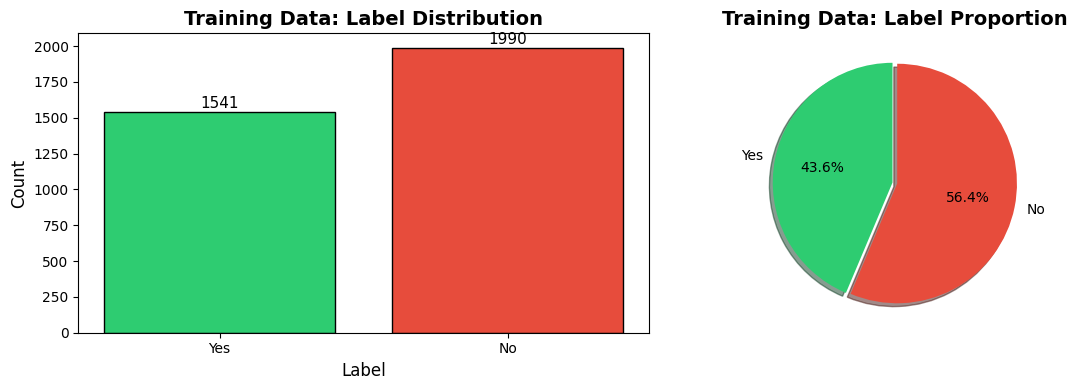

Saved: training_distributionn.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(label_counts.keys(), label_counts.values(), color=colors, edgecolor='black')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Training Data: Label Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, label_counts.values()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 str(count), ha='center', va='bottom', fontsize=11)

axes[1].pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', 
            colors=colors, explode=(0.02, 0.02), shadow=True, startangle=90)
axes[1].set_title('Training Data: Label Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('training_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: training_distributionn.png")

# prepare training data

In [11]:
# Convert to Hugging Face Dataset
train_dataset = Dataset.from_list(train_data)

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# Tokenize and encode labels
print("Tokenizing training data...")
tokenized_train_dataset = tokenize_data(train_dataset, tokenizer)
encoded_train_dataset = encode_labels(tokenized_train_dataset, LABEL_TO_ID)
print(f"   Features: {encoded_train_dataset.features}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizing training data...


Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

Map:   0%|          | 0/3531 [00:00<?, ? examples/s]

   Features: {'_id': Value('string'), 'text': Value('string'), 'subreddit': Value('string'), 'conspiracy': Value('string'), 'markers': List({'endIndex': Value('int64'), 'startIndex': Value('int64'), 'text': Value('string'), 'type': Value('string')}), 'annotator': Value('string'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': Value('int64')}


# load model

In [13]:
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=NUM_LABELS, 
    id2label=ID_TO_LABEL,
    label2id=LABEL_TO_ID
)

print(f" Model loaded: {MODEL_NAME}")
print(f"   Number of labels: {NUM_LABELS}")
print(f"   Parameters: {model.num_parameters():,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded: distilbert-base-uncased
   Number of labels: 2
   Parameters: 66,955,010


# training argumen

In [14]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)

training_logger = TrainingLoggerCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    tokenizer=tokenizer,
    callbacks=[training_logger]
)

print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Weight decay: {WEIGHT_DECAY}")

   Batch size: 16
   Learning rate: 2e-05
   Epochs: 10
   Weight decay: 0.01


# training

In [15]:
train_result = trainer.train()

print("=" * 50)
print("kelar")
print("=" * 50)

print(f"   Total steps: {train_result.global_step}")
print(f"   Training loss: {train_result.training_loss:.4f}")
print(f"   Training time: {train_result.metrics.get('train_runtime', 0):.1f} seconds")

Step,Training Loss
10,0.686300
20,0.671100
30,0.655000
40,0.648500
50,0.638000
60,0.662000
70,0.634200
80,0.612400
90,0.608500
100,0.578300


kelar
   Total steps: 1110
   Training loss: 0.2427
   Training time: 385.9 seconds


# training loss visualisasi

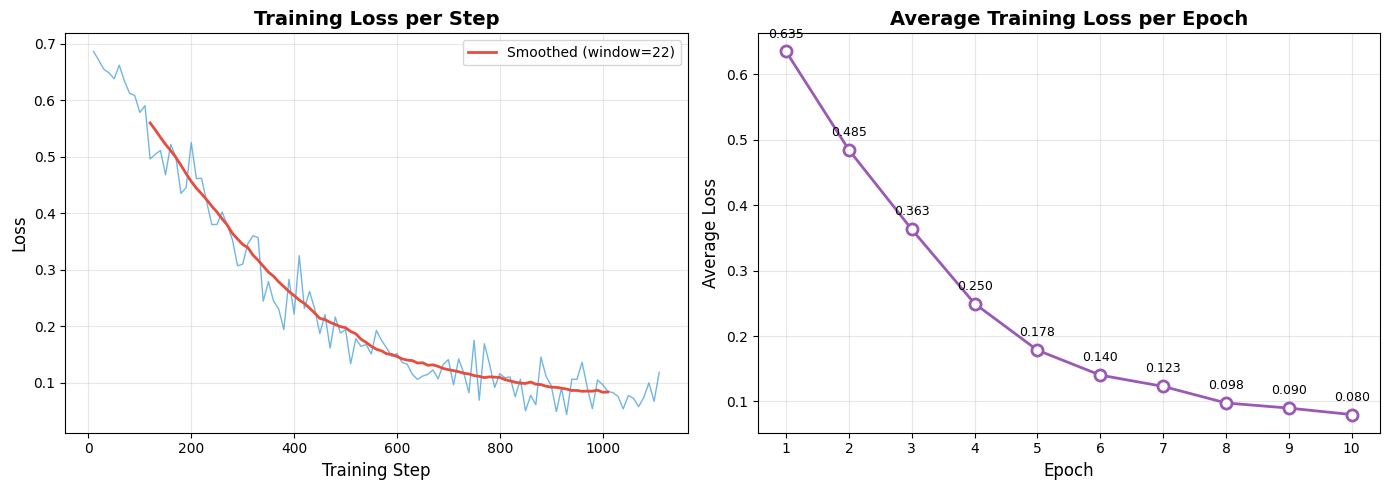

In [16]:
# Plot training loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss per step
if training_logger.train_losses:
    axes[0].plot(training_logger.train_steps, training_logger.train_losses, 
                 color='#3498db', alpha=0.7, linewidth=1)
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss per Step', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Add smoothed line
    if len(training_logger.train_losses) > 10:
        window = min(50, len(training_logger.train_losses)//5)
        smoothed = pd.Series(training_logger.train_losses).rolling(window=window, center=True).mean()
        axes[0].plot(training_logger.train_steps, smoothed, color='#e74c3c', 
                     linewidth=2, label=f'Smoothed (window={window})')
        axes[0].legend()

# Plot 2: Loss per epoch (aggregated)
if training_logger.train_losses:
    # Aggregate losses per epoch
    steps_per_epoch = len(training_logger.train_losses) // NUM_EPOCHS
    epoch_avg_losses = []
    for i in range(NUM_EPOCHS):
        start_idx = i * steps_per_epoch
        end_idx = start_idx + steps_per_epoch if i < NUM_EPOCHS - 1 else len(training_logger.train_losses)
        if start_idx < len(training_logger.train_losses):
            epoch_avg_losses.append(np.mean(training_logger.train_losses[start_idx:end_idx]))
    
    epochs = list(range(1, len(epoch_avg_losses) + 1))
    axes[1].plot(epochs, epoch_avg_losses, 'o-', color='#9b59b6', 
                 linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Average Loss', fontsize=12)
    axes[1].set_title('Average Training Loss per Epoch', fontsize=14, fontweight='bold')
    axes[1].set_xticks(epochs)
    axes[1].grid(True, alpha=0.3)
    
    # Annotate points
    for i, loss in enumerate(epoch_avg_losses):
        axes[1].annotate(f'{loss:.3f}', (epochs[i], loss), 
                        textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# INFERENCE

In [17]:
# Load test data
raw_test_data = load_competition_test_data(TEST_FILE)
print(f"Loaded {len(raw_test_data)} test samples")

# Store ground truth labels if available (for evaluation)
test_true_labels = [item['conspiracy'] for item in raw_test_data if item['conspiracy'] is not None]
has_ground_truth = len(test_true_labels) == len(raw_test_data)
print(f"Ground truth available: {has_ground_truth}")

# Convert to Hugging Face Dataset
test_dataset = Dataset.from_list(raw_test_data)
unique_ids = test_dataset["unique_sample_id"]
test_texts = test_dataset["text"]

Loaded 100 test samples
Ground truth available: False


In [18]:
def find_latest_checkpoint(base_path):
    """Find the latest checkpoint directory."""
    checkpoint_dirs = glob.glob(os.path.join(base_path, "checkpoint-*"))
    if not checkpoint_dirs:
        return base_path
    checkpoint_dirs.sort(key=lambda x: int(os.path.basename(x).split('-')[-1]))
    return checkpoint_dirs[-1]

# Find and load the trained model
model_directory = find_latest_checkpoint(OUTPUT_DIR)
print(f"Loading model from: {model_directory}")

# Load model for inference
inference_tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
inference_model = DistilBertForSequenceClassification.from_pretrained(model_directory)

# Tokenize test data
tokenized_test_dataset = tokenize_data(test_dataset, inference_tokenizer)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["unique_sample_id", "text", "conspiracy"])

# Setup inference
data_collator = DataCollatorWithPadding(tokenizer=inference_tokenizer)
inference_trainer = Trainer(
    model=inference_model,
    args=TrainingArguments(
        output_dir="./tmp_inference",
        per_device_eval_batch_size=64,
        report_to="none"
    ),
    data_collator=data_collator
)

# Run prediction
predictions_output = inference_trainer.predict(tokenized_test_dataset)
logits = predictions_output.predictions
predicted_class_ids = np.argmax(logits, axis=-1)
predicted_labels = [ID_TO_LABEL[int(id)] for id in predicted_class_ids]

Loading model from: distilbert-conspiracy-classification/checkpoint-1110


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

# eval n conf matrix

In [19]:
if has_ground_truth:
    # Calculate metrics
    y_true = [LABEL_TO_ID[label] for label in test_true_labels]
    y_pred = predicted_class_ids
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("=" * 60)
    print("EVALUATION METRICS")
    print("=" * 60)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print("-" * 60)
    print(f"Confusion Matrix:")
    print(f"  TN: {tn}  |  FP: {fp}")
    print(f"  FN: {fn}  |  TP: {tp}")
    print("=" * 60)
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No', 'Yes']))
else:
    print("No ground truth labels available for evaluation")

No ground truth labels available for evaluation


In [20]:
if has_ground_truth:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Confusion Matrix (counts)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                ax=axes[0], annot_kws={'size': 16})
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    
    # Plot 2: Confusion Matrix (normalized)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                ax=axes[1], annot_kws={'size': 14})
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_title('Confusion Matrix (Normalized by Row)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

In [21]:
if has_ground_truth:
    # Create metrics visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Bar chart of metrics
    metrics_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
    metrics_values = [precision, recall, f1, accuracy]
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
    
    bars = axes[0].bar(metrics_names, metrics_values, color=colors, edgecolor='black')
    axes[0].set_ylim(0, 1.0)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    axes[0].axhline(y=0.76, color='gray', linestyle='--', label='Expected baseline (~0.76)')
    axes[0].legend()
    
    # Add value labels on bars
    for bar, val in zip(bars, metrics_values):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                     f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 2: Confusion matrix components
    cm_components = ['True Neg\n(TN)', 'False Pos\n(FP)', 'False Neg\n(FN)', 'True Pos\n(TP)']
    cm_values = [tn, fp, fn, tp]
    cm_colors = ['#2ecc71', '#e74c3c', '#e67e22', '#3498db']
    
    bars2 = axes[1].bar(cm_components, cm_values, color=cm_colors, edgecolor='black')
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Confusion Matrix Components', fontsize=14, fontweight='bold')
    
    for bar, val in zip(bars2, cm_values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     str(val), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('metrics_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

# Error Analysis

In [22]:
if has_ground_truth:
    # Collect errors
    false_positives = []  # Predicted Yes, Actually No
    false_negatives = []  # Predicted No, Actually Yes
    
    for i in range(len(test_true_labels)):
        true_label = test_true_labels[i]
        pred_label = predicted_labels[i]
        text = test_texts[i]
        
        if true_label == "No" and pred_label == "Yes":
            false_positives.append({
                'id': unique_ids[i],
                'text': text,
                'true': true_label,
                'pred': pred_label
            })
        elif true_label == "Yes" and pred_label == "No":
            false_negatives.append({
                'id': unique_ids[i],
                'text': text,
                'true': true_label,
                'pred': pred_label
            })
    
    print("=" * 70)
    print("ERROR ANALYSIS HIGHLIGHTS")
    print("=" * 70)
    
    # False Positives Analysis
    print(f"\n False Positives: {len(false_positives)} samples")
    print("   (Model predicted 'Yes' but actual is 'No')")
    if false_positives:
        fp_texts = [item['text'] for item in false_positives]
        fp_lengths = [len(text.split()) for text in fp_texts]
        print(f"   Average text length: {np.mean(fp_lengths):.1f} words")
        print("\n   📝 Examples:")
        for i, item in enumerate(false_positives[:2]):
            print(f"\n   Example {i+1}:")
            print(f"   Text: {item['text'][:300]}...")
    
    # False Negatives Analysis
    print(f"\n\n False Negatives: {len(false_negatives)} samples")
    print("   (Model predicted 'No' but actual is 'Yes')")
    if false_negatives:
        fn_texts = [item['text'] for item in false_negatives]
        fn_lengths = [len(text.split()) for text in fn_texts]
        print(f"   Average text length: {np.mean(fn_lengths):.1f} words")
        print("\n   📝 Examples:")
        for i, item in enumerate(false_negatives[:2]):
            print(f"\n   Example {i+1}:")
            print(f"   Text: {item['text'][:300]}...")
    
    print("\n" + "=" * 70)

In [23]:
if has_ground_truth:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Error Type Distribution
    error_types = ['Correct\nPredictions', 'False Positives\n(FP)', 'False Negatives\n(FN)']
    error_counts = [len(predicted_labels) - len(false_positives) - len(false_negatives), 
                    len(false_positives), len(false_negatives)]
    colors_err = ['#2ecc71', '#e74c3c', '#e67e22']
    
    bars = axes[0, 0].bar(error_types, error_counts, color=colors_err, edgecolor='black')
    axes[0, 0].set_ylabel('Count', fontsize=12)
    axes[0, 0].set_title('Prediction Breakdown', fontsize=14, fontweight='bold')
    for bar, val in zip(bars, error_counts):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        str(val), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 2: Error Rate by Type (Pie)
    if len(false_positives) > 0 or len(false_negatives) > 0:
        axes[0, 1].pie([len(false_positives), len(false_negatives)], 
                       labels=['False Positives', 'False Negatives'],
                       autopct='%1.1f%%', colors=['#e74c3c', '#e67e22'],
                       explode=(0.05, 0.05), shadow=True, startangle=90)
        axes[0, 1].set_title('Error Type Distribution', fontsize=14, fontweight='bold')
    else:
        axes[0, 1].text(0.5, 0.5, 'No Errors!', ha='center', va='center', fontsize=16)
        axes[0, 1].set_title('Error Type Distribution', fontsize=14, fontweight='bold')
    
    # Plot 3: Text Length Distribution for Errors
    correct_texts = [test_texts[i] for i in range(len(test_texts)) 
                     if test_true_labels[i] == predicted_labels[i]]
    
    correct_lengths = [len(t.split()) for t in correct_texts]
    fp_lengths = [len(item['text'].split()) for item in false_positives] if false_positives else [0]
    fn_lengths = [len(item['text'].split()) for item in false_negatives] if false_negatives else [0]
    
    data_to_plot = [correct_lengths, fp_lengths, fn_lengths]
    bp = axes[1, 0].boxplot(data_to_plot, labels=['Correct', 'False Pos', 'False Neg'],
                            patch_artist=True)
    colors_box = ['#2ecc71', '#e74c3c', '#e67e22']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    axes[1, 0].set_ylabel('Word Count', fontsize=12)
    axes[1, 0].set_title('Text Length Distribution by Prediction Type', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Confidence Distribution (using softmax of logits)
    softmax_probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    confidence_scores = np.max(softmax_probs, axis=1)
    
    # Separate confidence by correctness
    correct_mask = np.array([test_true_labels[i] == predicted_labels[i] for i in range(len(predicted_labels))])
    correct_conf = confidence_scores[correct_mask]
    incorrect_conf = confidence_scores[~correct_mask]
    
    axes[1, 1].hist([correct_conf, incorrect_conf], bins=20, label=['Correct', 'Incorrect'],
                    color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Prediction Confidence', fontsize=12)
    axes[1, 1].set_ylabel('Count', fontsize=12)
    axes[1, 1].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

In [24]:
if has_ground_truth:
    # Create confidence heatmap by true label
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get confidence for predicted class
    pred_confidence_no = softmax_probs[:, 0]  # Confidence for "No"
    pred_confidence_yes = softmax_probs[:, 1]  # Confidence for "Yes"
    
    # Create bins for confidence
    conf_bins = np.linspace(0.5, 1.0, 11)
    
    # Separate by true label and prediction correctness
    data_for_heatmap = []
    categories = []
    
    for true_label in ['No', 'Yes']:
        for pred_correct in [True, False]:
            mask = np.array([(test_true_labels[i] == true_label) and 
                            ((test_true_labels[i] == predicted_labels[i]) == pred_correct)
                            for i in range(len(predicted_labels))])
            if mask.sum() > 0:
                confs = confidence_scores[mask]
                hist, _ = np.histogram(confs, bins=conf_bins)
                data_for_heatmap.append(hist)
                status = "Correct" if pred_correct else "Wrong"
                categories.append(f"True={true_label}, {status}")
    
    if data_for_heatmap:
        heatmap_data = np.array(data_for_heatmap)
        sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd',
                    xticklabels=[f'{conf_bins[i]:.2f}-{conf_bins[i+1]:.2f}' for i in range(len(conf_bins)-1)],
                    yticklabels=categories, ax=ax)
        ax.set_xlabel('Confidence Range', fontsize=12)
        ax.set_ylabel('Category', fontsize=12)
        ax.set_title('Prediction Confidence Heatmap by Category', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('confidence_heatmap.png', dpi=150, bbox_inches='tight')
        plt.show()

# generate submission

In [25]:
# Save results in Codabench-ready JSONL format
print(f"Saving {len(predicted_labels)} predictions to {SUBMISSION_FILE}...")

jsonl_lines = []
for i, label in enumerate(predicted_labels):
    jsonl_obj = {
        "_id": unique_ids[i],
        "conspiracy": label
    }
    jsonl_lines.append(json.dumps(jsonl_obj))

with open(SUBMISSION_FILE, 'w') as f:
    f.write('\n'.join(jsonl_lines) + '\n')

print(f"Submission file '{SUBMISSION_FILE}' generated!")

# Preview first few lines
print("\npreview:")
for line in jsonl_lines[:3]:
    print(f"   {line}")
print("   ...")

Saving 100 predictions to submission.jsonl...
Submission file 'submission.jsonl' generated!

preview:
   {"_id": "t1_emz6exn", "conspiracy": "Yes"}
   {"_id": "t1_f07ejkp", "conspiracy": "Yes"}
   {"_id": "t1_f6mnlr1", "conspiracy": "Yes"}
   ...


In [26]:
import zipfile

ZIP_FILE = "submission.zip"

with zipfile.ZipFile(ZIP_FILE, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(SUBMISSION_FILE)

print(f"   File size: {os.path.getsize(ZIP_FILE):,} bytes")

   File size: 865 bytes


In [27]:
print("=" * 70)
print(" FINAL SUMMARY - CONSPIRACY DETECTION BASELINE")
print("=" * 70)
print(f"\n🔧 Model: {MODEL_NAME}")
print(f"   - Epochs: {NUM_EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"\n Dataset:")
print(f"   - Training samples: {len(train_data)}")
print(f"   - Test samples: {len(predicted_labels)}")

if has_ground_truth:
    print(f"\n Performance Metrics:")
    print(f"   - Precision: {precision:.4f}")
    print(f"   - Recall:    {recall:.4f}")
    print(f"   - F1 Score:  {f1:.4f}")
    print(f"   - Accuracy:  {accuracy:.4f}")
    print(f"\n Confusion Matrix:")
    print(f"   - TN: {tn} | FP: {fp}")
    print(f"   - FN: {fn} | TP: {tp}")
    print(f"\n Error Analysis:")
    print(f"   - False Positives: {len(false_positives)}")
    print(f"   - False Negatives: {len(false_negatives)}")

 FINAL SUMMARY - CONSPIRACY DETECTION BASELINE

🔧 Model: distilbert-base-uncased
   - Epochs: 10
   - Batch size: 16
   - Learning rate: 2e-05

 Dataset:
   - Training samples: 3531
   - Test samples: 100


In [28]:
# from IPython.display import FileLink

# print(" Download your files:")
# display(FileLink(ZIP_FILE))
# display(FileLink(SUBMISSION_FILE))
# print("\n Visualizations saved in working directory")

 Download your files:


/kaggle/working/submission.zip

/kaggle/working/submission.jsonl


 Visualizations saved in working directory
